r= PearsonRResult(statistic=-0.13988476096640207, pvalue=0.09804661812998021)
r1= PearsonRResult(statistic=-0.11698853081081392, pvalue=0.167111480328829)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


m = -0.2 ± 0.12
b = 2.9 ± 0.042
sigma [dex] = 0.16 ± 0.011
corr = -0.14 ± 0.09
tau = 858.21^{+78.23}_{-86.73} (M/1e8Msun)^{ -0.19^{+0.12}_{-0.12} }


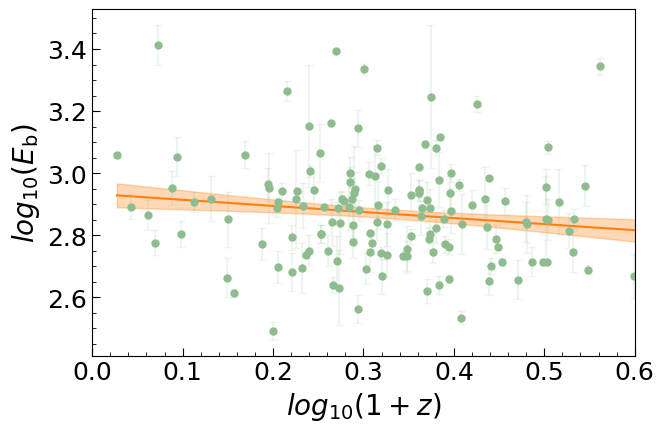

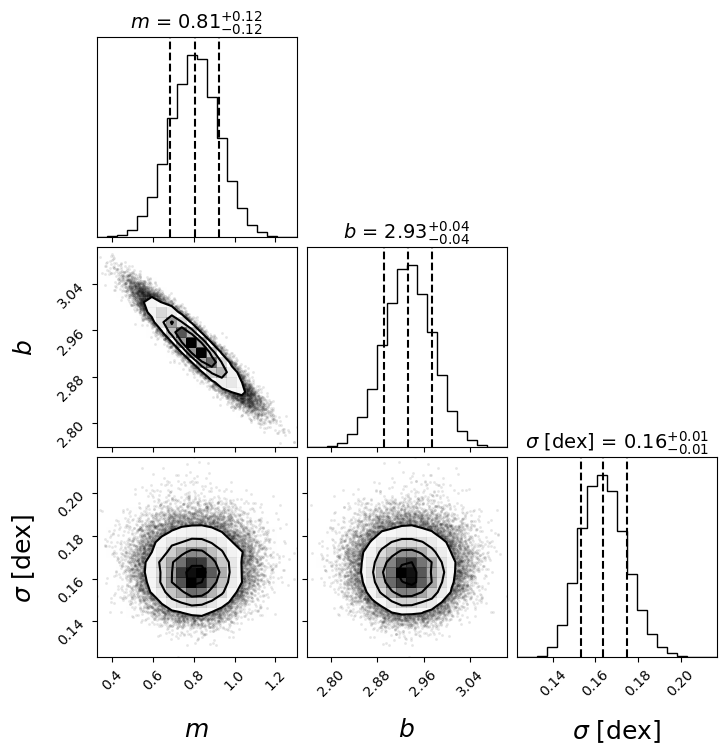

In [1]:
import linmix.linmix as linmix
from matplotlib import cm
from matplotlib.colors import LogNorm
import matplotlib.pyplot as plt
import numpy as np
import corner
#from labellines import labelLine, labelLines
import emcee

def fit_line_linmix(x, y, xerr, yerr, nchains=4, seed=None):
    """
    Fit line using LinMix
    """ 
    lm = linmix.LinMix(x, y, xsig=xerr, ysig=yerr, K=2, nchains=nchains, seed=seed)
    lm.run_mcmc(silent=True)

    # Print results
    samples = lm.chain
    print("m = {0:.2} ± {1:.2}".format(np.mean(samples['beta']), np.std(samples['beta'])))
    print("b = {0:.2} ± {1:.2}".format(np.mean(samples['alpha']), np.std(samples['alpha'])))
    print("sigma [dex] = {0:.2} ± {1:.2}".format(np.mean(np.sqrt(samples['sigsqr'])), np.std(np.sqrt(samples['sigsqr']))))
    print("corr = {0:.2} ± {1:.2}".format(np.mean(samples['corr']), np.std(samples['corr'])))
    return samples

def draws_CI_linmix(x_eval, samples):
    draws = np.empty((len(x_eval), len(samples)))
    for i,s in enumerate(samples):
        draws[:, i]  = s['alpha'] + x_eval*s['beta']

    # Compute credibility interval
    draws_credint = np.empty((len(x_eval), 3))
    draws_credint[:, 0] = np.percentile(draws, 16, axis=1)
    draws_credint[:, 2] = np.percentile(draws, 84, axis=1)
    draws_credint[:, 1] = np.median(draws, axis=1)
    
    return draws_credint


fig,ax = plt.subplots(1,1, figsize=(7,4.5), sharey=True)
#ax.set_xscale('log')
#ax.set_yscale('log')

data = np.genfromtxt("Eb_redshift.txt")

Eb=data[:,1]
Eb_err=data[:,2]
redshift=data[:,3]



log_Eb = np.log10(Eb)
log_Eb_err = np.log10(Eb+Eb_err)-np.log10(Eb)
log_redshift = np.log10(redshift+1.)


# Error bars
m,c,b = ax.errorbar(log_redshift, log_Eb, yerr=log_Eb_err,
                    linestyle='', fmt='o',color='darkseagreen', ms=5,
                    ecolor='darkseagreen', capsize=3, zorder=-1)

[i.set_alpha(0.15) for i in b]
[i.set_alpha(0.15) for i in c]

from scipy.stats import pearsonr
print('r=', pearsonr(log_redshift, log_Eb))
print('r1=', pearsonr(redshift+1., Eb))

xerr = np.zeros(len(log_Eb_err))
samples = fit_line_linmix(log_redshift, log_Eb, xerr=xerr,yerr=log_Eb_err, nchains=16, seed=50)
x_eval = np.linspace(np.min(log_redshift),np.max(log_redshift),50)
draws_credint = draws_CI_linmix(x_eval, samples)

# Plot
ax.fill_between(x_eval, draws_credint[:, 2], draws_credint[:, 0],color="#ff7f0e", alpha=0.3, zorder=-5)
ax.plot(x_eval, draws_credint[:, 1], color="#ff7f0e", zorder=-4)



ax.tick_params('both',labelsize=18)
ax.set_xlabel(r'$log_{10}(1+z)$',fontsize=20)
ax.set_ylabel(r'$log_{10}(E_{\rm{b}})$',fontsize=20)


ax.minorticks_on()
ax.tick_params(axis='both', which='both', direction='in')
ax.tick_params(axis='both', which='major', length=6)
ax.tick_params(axis='both', which='minor', length=3)


ax.legend(fontsize=16, loc=2, frameon=False)
#fig.tight_layout()
ax.set_xlim(0, 0.6)
fig.savefig('Eb-1+z.pdf', dpi=300, bbox_inches='tight')


fig = corner.corner(np.array([1.+samples['beta'], samples['alpha'], np.sqrt(samples['sigsqr'])]).T,
             labels=["$m$", "$b$", "$\sigma$ [dex]"], quantiles=[0.16,0.5,0.84], show_titles=True,
             label_kwargs=dict(fontsize=18), title_kwargs=dict(fontsize=14));
fig.savefig('E-z_param.pdf')

# PRINT FITTING 

print('tau = %0.2f^{+%0.2f}_{%0.2f} (M/1e8Msun)^{ %0.2f^{+%0.2f}_{%0.2f} }' %
      (np.median(10**samples['alpha']),
       np.median(10**samples['alpha']) - np.percentile(10**samples['alpha'], 16),
       np.median(10**samples['alpha']) - np.percentile(10**samples['alpha'], 84),
       np.median(samples['beta']),
       np.median(samples['beta']) - np.percentile(samples['beta'], 16),
       np.median(samples['beta']) - np.percentile(samples['beta'], 84) ) )



In [2]:
np.savetxt('cel_'+'_parSamples.txt', np.array([samples['beta'], samples['alpha'], np.sqrt(samples['sigsqr'])]).T)
print (samples['beta']+1.)
print (np.shape(samples['beta']))

[0.75121642 0.73082229 0.66192208 ... 0.85844492 0.88719978 0.77084001]
(40000,)
